# Orchestration of LUME Workflows

## Imports

In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

# Nicer plotting
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6,6)
%config InlineBackend.figure_format = 'retina'

In [2]:
from prefect import Flow, task, Task

In [3]:
from distgen import Generator
from astra import Astra
from impact import Impact

In [4]:
import os
os.environ["ASTRA_BIN"] = "~/sandbox/git-lume/lume-astra/examples/Astra"
os.environ["GENERATOR_BIN"] = "~/sandbox/git-lume/lume-astra/examples/generator"

In [5]:
@task
def task_distgen(input_file):
    G = Generator(input_file)
    G['n_particle'] = 10000
    G.verbose = False
    G.run()
    return G

@task
def task_astra(input_file, generator):
    if generator:
        A = Astra(input_file=input_file, initial_particles=generator.output)
    else:
        A = Astra(input_file=input_file, initial_particles=None)
    A.verbose = False
    A.run()
    return A

@task
def task_impact(input_file, generator):
    I = Impact(input_file=input_file, initial_particles=generator.output)
    I.distgen_input = generator.input
    I.verbose = False    
    # Turn space charge off
    I.total_charge = 0
    I.stop = 0.5
    I.run()
    return I

In [6]:
distgen_input = "~/sandbox/git-lume/lume-astra/examples/templates/apex_gun/distgen.yaml"
astra_input = "~/sandbox/git-lume/lume-astra/examples/templates/apex_gun/astra.in"
impact_input = "~/sandbox/git-lume/lume-impact/templates/apex_gun/ImpactT.in"

In [7]:
with Flow("Distgen->Astra&Impact") as flow:
    G = task_distgen(distgen_input)
    A = task_astra(astra_input, G)    
    I = task_impact(impact_input, G)

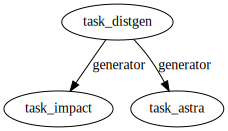

In [8]:
flow.visualize()

In [9]:
%%time
state = flow.run()

[2021-10-12 14:10:40-0700] INFO - prefect.FlowRunner | Beginning Flow run for 'Distgen->Astra&Impact'
[2021-10-12 14:10:40-0700] INFO - prefect.TaskRunner | Task 'task_distgen': Starting task run...
[2021-10-12 14:10:40-0700] INFO - prefect.TaskRunner | Task 'task_distgen': Finished task run for task with final state: 'Success'
[2021-10-12 14:10:40-0700] INFO - prefect.TaskRunner | Task 'task_impact': Starting task run...
[2021-10-12 14:11:16-0700] INFO - prefect.TaskRunner | Task 'task_impact': Finished task run for task with final state: 'Success'
[2021-10-12 14:11:16-0700] INFO - prefect.TaskRunner | Task 'task_astra': Starting task run...
configure_astra:  $ASTRA_BIN
configure_astra:  /Volumes/SlepickaHD/Users/slepicka/sandbox/git-lume/lume-astra/examples/Astra
Initial Particles:  ParticleGroup with 10000 particles with total charge 1.0000000000000004e-10 C
[2021-10-12 14:13:26-0700] INFO - prefect.TaskRunner | Task 'task_astra': Finished task run for task with final state: 'Succes

In [10]:
state

<Success: "All reference tasks succeeded.">

# Making it Parallel

In [11]:
from prefect.executors.dask import LocalDaskExecutor

In [12]:
executor = LocalDaskExecutor(scheduler="threads")

In [13]:
%%time
state = flow.run(executor=executor)

[2021-10-12 14:13:46-0700] INFO - prefect.FlowRunner | Beginning Flow run for 'Distgen->Astra&Impact'
[2021-10-12 14:13:46-0700] INFO - prefect.TaskRunner | Task 'task_distgen': Starting task run...
[2021-10-12 14:13:46-0700] INFO - prefect.TaskRunner | Task 'task_distgen': Finished task run for task with final state: 'Success'
[2021-10-12 14:13:46-0700] INFO - prefect.TaskRunner | Task 'task_astra': Starting task run...
[2021-10-12 14:13:46-0700] INFO - prefect.TaskRunner | Task 'task_impact': Starting task run...
configure_astra:  $ASTRA_BIN
configure_astra:  /Volumes/SlepickaHD/Users/slepicka/sandbox/git-lume/lume-astra/examples/Astra
Initial Particles:  ParticleGroup with 10000 particles with total charge 1.0000000000000004e-10 C
[2021-10-12 14:14:23-0700] INFO - prefect.TaskRunner | Task 'task_impact': Finished task run for task with final state: 'Success'
[2021-10-12 14:15:58-0700] INFO - prefect.TaskRunner | Task 'task_astra': Finished task run for task with final state: 'Succes

In [14]:
state

<Success: "All reference tasks succeeded.">

# Accessing Output

In [15]:
state

<Success: "All reference tasks succeeded.">

In [16]:
state.result

{<Task: task_distgen>: <Success: "Task run succeeded.">,
 <Task: task_impact>: <Success: "Task run succeeded.">,
 <Task: task_astra>: <Success: "Task run succeeded.">}

In [17]:
g = state.result[G].result
a = state.result[A].result
i = state.result[I].result

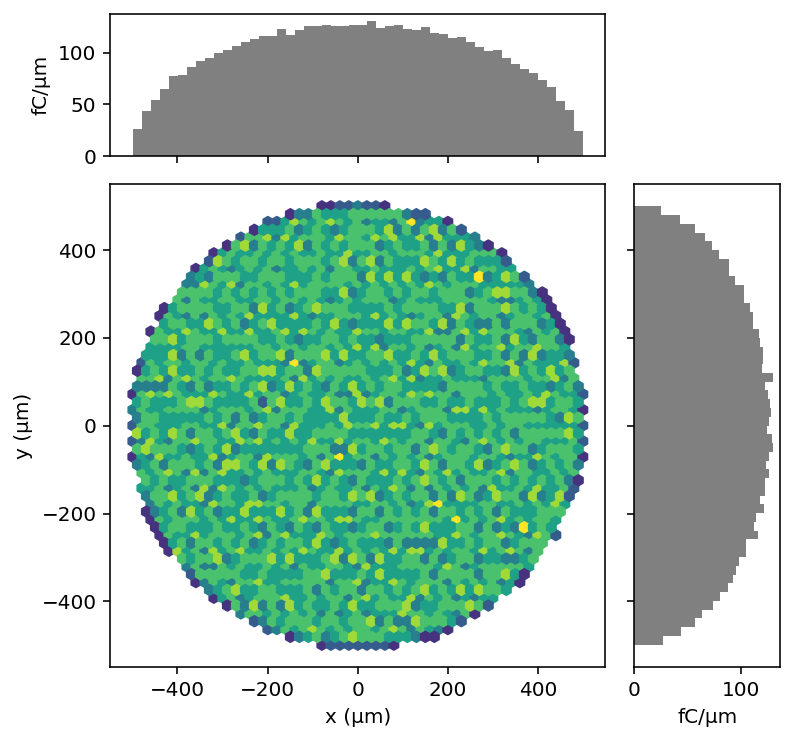

In [18]:
g.particles.plot('x', 'y', bins=50)

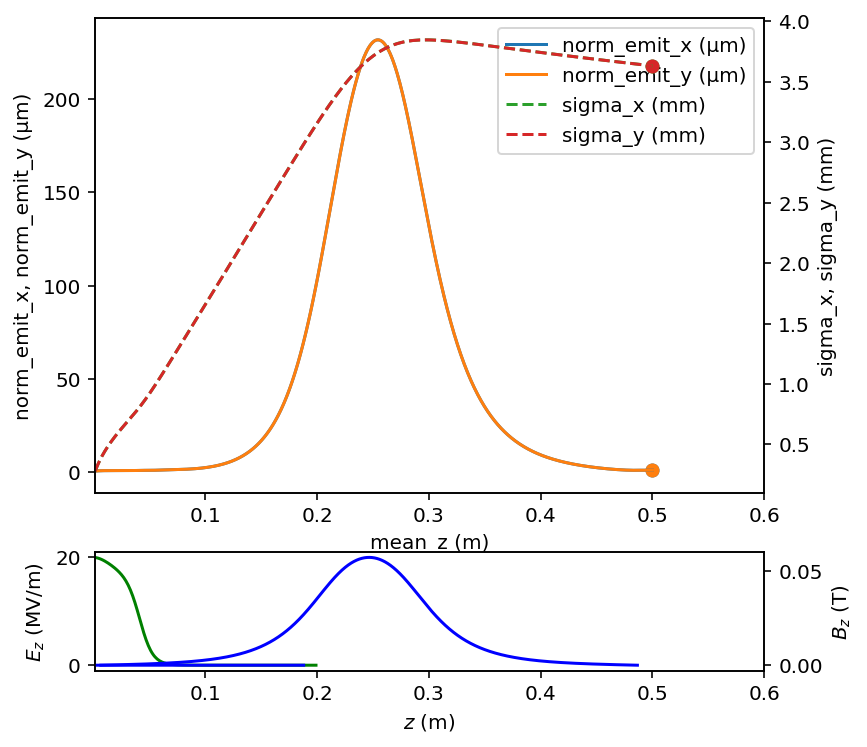

In [19]:
a.plot(
    y=['norm_emit_x', 'norm_emit_y'],
    y2=['sigma_x', 'sigma_y'],
    xlim=(1e-3,.6),
    figsize=(6, 6)
)

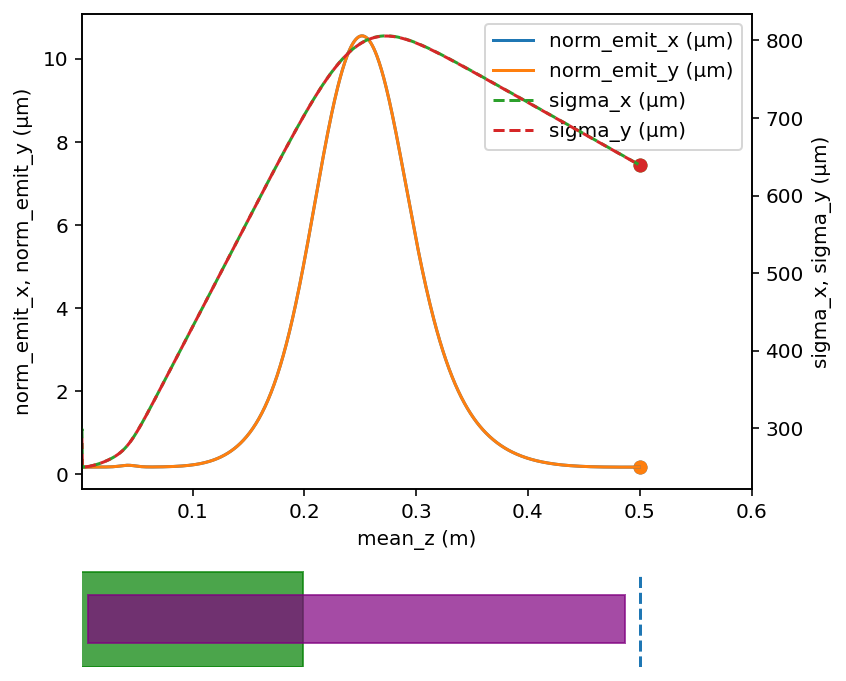

In [20]:
i.plot(
    y=['norm_emit_x', 'norm_emit_y'],
    y2=['sigma_x', 'sigma_y'],
    xlim=(1e-3,.6),
    figsize=(6,6)
)